In [1]:
import random
import numpy as np
import tensorflow.keras
#import wandb
#from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
# load data

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

11493376/11490434 [==============================] - 2s 0us/step


In [36]:
x_train[0].shape

(28, 28)

In [18]:
np.where(y_train == 5)[0]

array([    0,    11,    35, ..., 59968, 59993, 59997])

In [12]:
y_train[35]

5

In [23]:
random.choice([1,2,3,1,3,4,3,2,2,3,3,3])

1

In [31]:
random.randint(0, 9)

9

In [32]:
# make pairs
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]
    
    #print(digit_indices)
    #print('len *****', len(digit_indices))
    #print('3 digit array', digit_indices[3])
    
    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [1]
    
        # add a not matching example
        label2 = random.randint(0, num_classes-1)
        while label2 == label1:
            label2 = random.randint(0, num_classes-1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels)

pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

In [33]:
pairs_train.shape

(120000, 2, 28, 28)

In [14]:
labels_train.shape

(120000,)

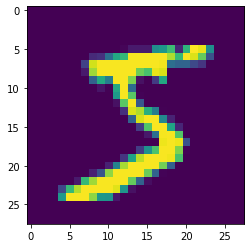

In [22]:
# take a peek at the data
plt.imshow(pairs_train[0,0])

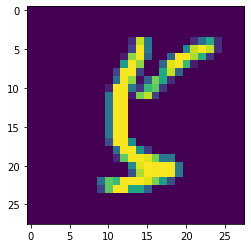

In [23]:
plt.imshow(pairs_train[0,1])

In [30]:
labels_train[0]

1

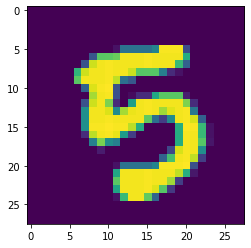

In [28]:
plt.imshow(pairs_train[1109,0])

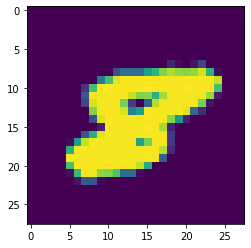

In [29]:
plt.imshow(pairs_train[1109,1])

In [31]:
labels_train[1109]

0

In [32]:
# Weights not shared

seq1 = Sequential()
seq1.add(Flatten(input_shape=(28,28)))
seq1.add(Dense(128, activation='relu'))

seq2 = Sequential()
seq2.add(Flatten(input_shape=(28,28)))
seq2.add(Dense(128, activation='relu'))

merge_layer = Concatenate()([seq1.output, seq2.output])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[seq1.input, seq2.input], outputs=dense_layer)

In [34]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [35]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs= 10)

Train on 120000 samples
Epoch 1/10
120000/120000 [==============================] - 26s 216us/sample - loss: 0.6946 - accuracy: 0.5002
Epoch 2/10
120000/120000 [==============================] - 20s 165us/sample - loss: 0.6933 - accuracy: 0.5046
Epoch 3/10
120000/120000 [==============================] - 19s 159us/sample - loss: 0.6931 - accuracy: 0.5048
Epoch 4/10
120000/120000 [==============================] - 19s 159us/sample - loss: 0.6927 - accuracy: 0.5121
Epoch 5/10
120000/120000 [==============================] - 29s 241us/sample - loss: 0.6924 - accuracy: 0.5124
Epoch 6/10
120000/120000 [==============================] - 26s 220us/sample - loss: 0.6919 - accuracy: 0.5153
Epoch 7/10
120000/120000 [==============================] - 25s 205us/sample - loss: 0.6911 - accuracy: 0.5181
Epoch 8/10
120000/120000 [==============================] - 20s 166us/sample - loss: 0.6904 - accuracy: 0.5177
Epoch 9/10
120000/120000 [==============================] - 22s 185us/sample - loss: 0.6

In [40]:
from tensorflow.keras import backend as K

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


input = Input((28,28))
x = Flatten()(input)
x = Dense(128, activation='relu')(x)
dense = Model(input, x)

input1 = Input((28,28))
input2 = Input((28,28))

dense1 = dense(input1)
dense2 = dense(input2)

merge_layer = Lambda(euclidean_distance)([dense1,dense2])
dense_layer = Dense(1, activation="sigmoid")(merge_layer)
model = Model(inputs=[input1, input2], outputs=dense_layer)

In [41]:
model.compile(loss = "binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 128)          100480      input_8[0][0]                    
                                                                 input_9[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           model_3[1][0]              

In [42]:
pairs_train[:,0].shape

(120000, 28, 28)

In [44]:
pairs_train[:,1].shape

(120000, 28, 28)

In [45]:
model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train[:], batch_size=16, epochs=10)

Train on 120000 samples
Epoch 1/10
120000/120000 [==============================] - 27s 223us/sample - loss: 0.4018 - accuracy: 0.8286
Epoch 2/10
120000/120000 [==============================] - 30s 250us/sample - loss: 0.3070 - accuracy: 0.8795
Epoch 3/10
120000/120000 [==============================] - 25s 205us/sample - loss: 0.2869 - accuracy: 0.8863
Epoch 4/10
120000/120000 [==============================] - 26s 218us/sample - loss: 0.2685 - accuracy: 0.8918
Epoch 5/10
120000/120000 [==============================] - 22s 187us/sample - loss: 0.2597 - accuracy: 0.8961
Epoch 6/10
120000/120000 [==============================] - 31s 255us/sample - loss: 0.2522 - accuracy: 0.9000
Epoch 7/10
120000/120000 [==============================] - 29s 243us/sample - loss: 0.2453 - accuracy: 0.9025
Epoch 8/10
120000/120000 [==============================] - 32s 264us/sample - loss: 0.2421 - accuracy: 0.9039
Epoch 9/10
120000/120000 [==============================] - 31s 262us/sample - loss: 0.2

Kaggle - Challenges in Representation Learning: Facial Expression Recognition Challenge
  * https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/discussion
  * https://www.youtube.com/watch?v=DtBu1u5aBsc

Sliding Window Classifier: Rain Drop Detection
  * https://github.com/tobybreckon/raindrop-detection-cnn/blob/master/raindrop_detection_sliding_window.py

Convolutional implementation of the sliding window algorithm
  * https://medium.com/ai-quest/convolutional-implementation-of-the-sliding-window-algorithm-db93a49f99a0